In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

# offset 
game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (10, 150, 550, 500))
camera = game_env.camera

(180, 180, 1)

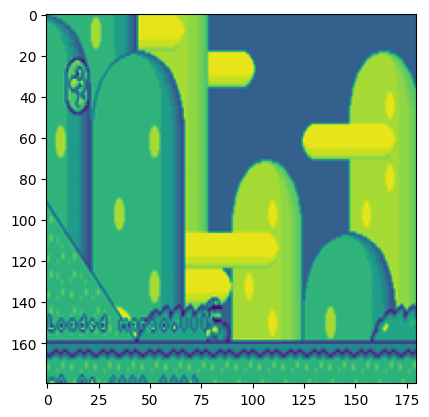

In [5]:
import numpy as np
frame = camera.get_frame()
plt.imshow(frame)
frame.shape

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

KeyboardInterrupt: 

In [ ]:
import gymnasium

# Register the custom environment with Gym
from gymnasium.envs.registration import register

register(
    id='CustomGameEnv-v0',
    entry_point='src.gamenv.gameenv:GameEnv',
    max_episode_steps=None,  # Adjust as needed
)

# Create the environment
# env = gymnasium.make('CustomGameEnv-v0')

# obs = env.reset()
# for _ in range(500):  # Adjust as needed
#     action = env.action_space.sample()  # Replace with your RL agent's action
#     obs, reward, done, truncated, info = env.step(action)
#     env.render()
#     if done or truncated:
#         obs = env.reset()
# env.close()

In [ ]:
import gymnasium
import numpy as np
from gymnasium import spaces

env = gymnasium.make('CustomGameEnv-v0')
keep_frames = 60  # Number of frames to stack
skip_frames = 4
n_stack = keep_frames // skip_frames

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def norm_obs(obs):
    obs = obs.astype(np.float32) / 255.0  # Scale to [0, 1]
    # Normalize the image
    return (obs - mean) / std

class FrameStackingWrapper(gymnasium.Wrapper):
    def __init__(self, env, keep_frames=4):
        super(FrameStackingWrapper, self).__init__(env)
        self.keep_frames = keep_frames
        self.frames = np.zeros((keep_frames, *env.observation_space.shape), dtype=np.float32)
        
        # self.observation_space = spaces.Box(low=-2.1179, high=2.6400, shape=(n_stack, 180, 180, 3), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_stack, 180, 180, 1), dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames = np.zeros((self.keep_frames, *self.env.observation_space.shape), dtype=np.float32)
        for i in range(self.keep_frames):
            self.frames[i] = obs.astype(np.float32) / 255.0 # norm_obs(obs)
        stacked_obs = np.array([self.frames[-1-i] for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])
        return stacked_obs, info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames[:-1] = self.frames[1:]  # Shift frames
        self.frames[-1] = obs.astype(np.float32) / 255.0 # norm_obs(obs) # add frame
        stacked_obs = np.array([self.frames[-1-i] for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])
        return stacked_obs, reward, done, truncated, info


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\envs\registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


In [ ]:
list([-1-i for i in range(keep_frames-1, -1, -1) if i % skip_frames==0])

[-57, -53, -49, -45, -41, -37, -33, -29, -25, -21, -17, -13, -9, -5, -1]

In [ ]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack

env = FrameStackingWrapper(env, keep_frames=keep_frames)

In [ ]:
obs, _ = env.reset()
obs.shape

(15, 180, 180, 1)

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gymnasium.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[-1]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 8, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()).permute(0,3,1,2).float()
            ).shape[1]
        self.lstm = nn.lSTM(input_size=n_flatten, hidden_size=features_dim, num_layers=1, batch_first=True)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        x = observations.permute(0,1,4,2,3)
        batch_size, seq_len, c, h, w = x.size()

        x = observations.view(batch_size * seq_len, c, h, w)

        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(batch_size, seq_len, -1)
        # lstm_out, (h_n, c_n) = self.lstm(cnn_out)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:,-1,:]
        return self.linear(lstm_out)

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=256),
)

model = PPO('CnnPolicy', env, verbose=2,
            learning_rate=1e-2,
            n_steps=1024,
            batch_size=64, 
            clip_range=0.1, 
            max_grad_norm=0.5,
            ent_coef=0.000001,
            n_epochs=10,
            # vf_coef=0.5,
            tensorboard_log="./ppo_super_mario_tensorboard/",
            policy_kwargs=policy_kwargs,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.policy

ActorCriticCnnPolicy(
  (features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (lstm): GRU(32, 256, batch_first=True)
  )
  (pi_features_extractor): CustomCNN(
    (cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (lstm): GRU(32, 256, batch_first=True)
  )
  (vf_features_ex

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class BeforeTrainingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(BeforeTrainingCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # This method needs to be implemented but can remain empty if not needed
        return True

    def _on_rollout_end(self) -> None:
        # This method is called before the training process starts after n_steps
        print("Rollout has ended, training is about to start.")
        env.toggle_pause()
    
    def _on_rollout_start(self) -> None:
        print("Training has ended!")
        env.toggle_pause()

# Create the callback
callback = BeforeTrainingCallback()

In [ ]:
# Train the model with the custom callback
model.learn(total_timesteps=50000, callback=callback)

Logging to ./ppo_super_mario_tensorboard/PPO_212
Training has ended!


c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.toggle_pause to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.toggle_pause` for environment variables or `env.get_wrapper_attr('toggle_pause')` that will search the reminding wrappers.
  logger.warn(


RuntimeError: input.size(-1) must be equal to input_size. Expected 32, got 3872

In [ ]:

# Retrieve the environment
# env = model.get_env()
# Train the agent
# model.learn(total_timesteps=100000)
# Save the agent

model.save("model")
# the policy_kwargs are automatically loaded